<a href="https://colab.research.google.com/github/kursatkara/MAE_5020_S24/blob/master/04_08_kFold_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**kFold Cross Validation**

The code from the textbook [1] was modified to run on Google Colab.

[1] https://github.com/kursatkara/databook_python/blob/master/CH04/CH04_SEC06_1_kFoldValidation.ipynb

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [12,12]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e+01, tolerance: 2.325e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.238e+01, tolerance: 2.306e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.240e+01, tolerance: 2.295e

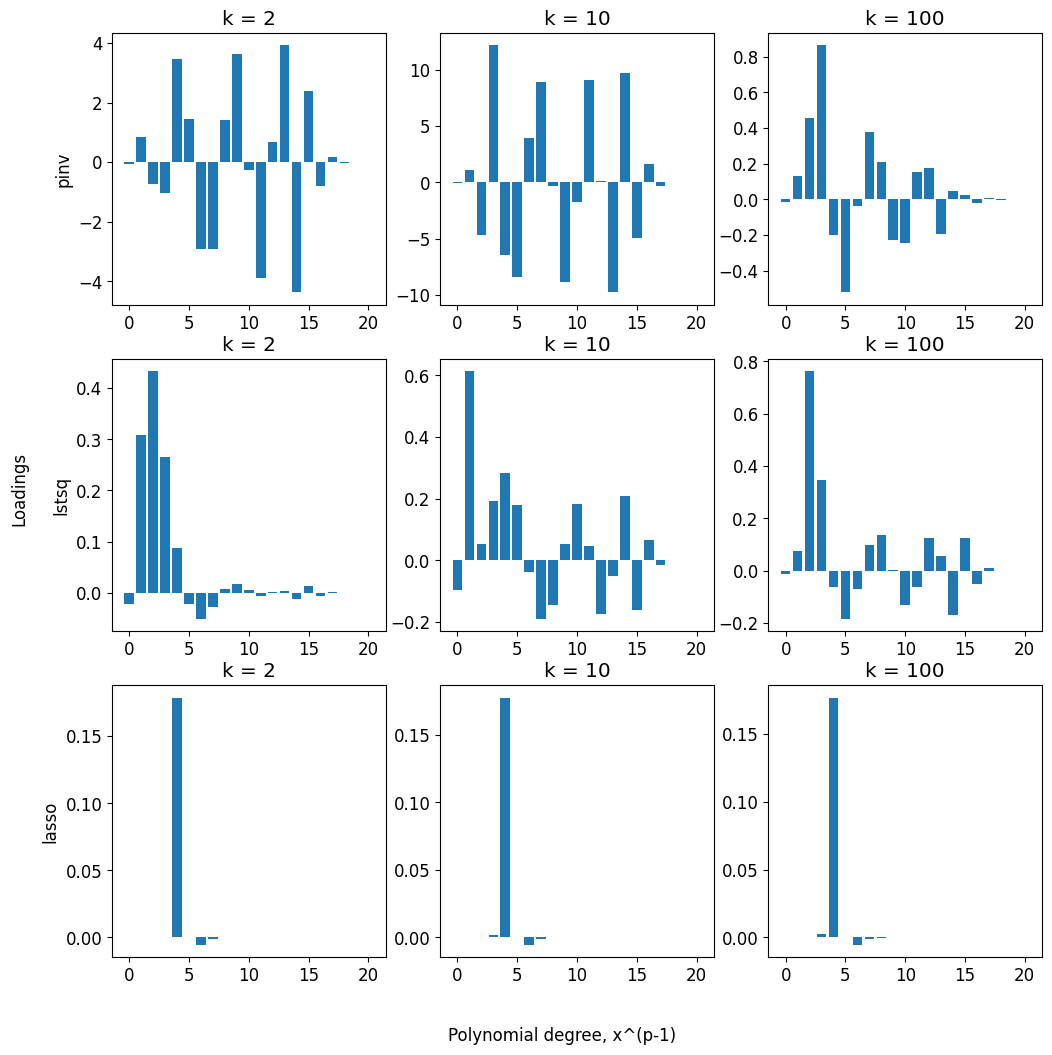

In [17]:
n = 100
L = 4
x = np.linspace(0,L,n)
f = np.power(x,2) # parabola with 100 data points

M = 21 # Polynomial degree
phi = np.zeros((n,M))
for j in range(M):
    phi[:,j] = np.power(x,j) # build matrix A

# k-fold cross validation
trials = np.array([2, 10, 100])

fig,axs = plt.subplots(3,3)

for j in range(len(trials)):
    trial = trials[j]
    E1 = np.zeros(trial)
    E2 = np.zeros(trial)
    E3 = np.zeros(trial)

    A1 = np.zeros((M,trial))
    A2 = np.zeros((M,trial))
    A3 = np.zeros((M,trial))


    for jj in range(trial):
        f = np.power(x,2) + 0.2*np.random.randn(n)

        ########################################################################
        # The pseudo-inverse of a matrix (pinv)
        a1 = np.linalg.pinv(np.copy(phi)) @ np.copy(f)
        f1 = phi @ a1
        E1[jj] = np.linalg.norm(f-f1,ord=2)/np.linalg.norm(f,ord=2)

        ########################################################################
        # The least-squares solution to a linear matrix equation (lstsq)
        a2 = np.linalg.lstsq(np.copy(phi),np.copy(f),rcond=None)[0]
        f2 = phi @ a2
        E2[jj] = np.linalg.norm(f-f2,ord=2)/np.linalg.norm(f,ord=2)

        ########################################################################
        #Linear Model trained with L1 prior as regularizer (aka the Lasso).
        regr3 = linear_model.Lasso(alpha=1)
        regr3.fit(phi, f)
        a3 = regr3.coef_
        f3 = phi @ a3
        E3[jj] = np.linalg.norm(f-f3,ord=2)/np.linalg.norm(f,ord=2)

        A1[:,jj] = a1
        A2[:,jj] = a2
        A3[:,jj] = a3

    # The mean of the elements along axis 1 (column-wise) of the array A1
    A1m = np.mean(A1,axis=1)
    A2m = np.mean(A2,axis=1)
    A3m = np.mean(A3,axis=1)

    Err = np.column_stack((E1,E2,E3))

    axs[0, j].bar(range(M),A1m)
    axs[0, j].set_title("k = " + str(trials[j]))
    axs[0, 0].set_ylabel('pinv')

    axs[1, j].bar(range(M),A2m)
    axs[1, j].set_title("k = " + str(trials[j]))
    axs[1, 0].set_ylabel('lstsq')

    axs[2, j].bar(range(M),A3m)
    axs[2, j].set_title("k = " + str(trials[j]))
    axs[2, 0].set_ylabel('lasso')

fig.text(0.5, 0.04, 'Polynomial degree, x^(p-1)', ha='center')
fig.text(0.04, 0.5, 'Loadings', va='center', rotation='vertical')
plt.show()

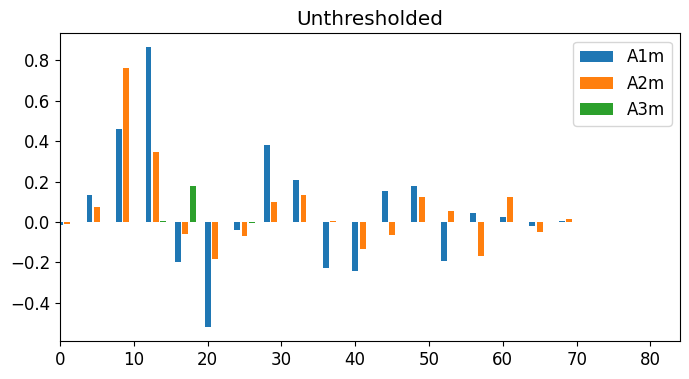

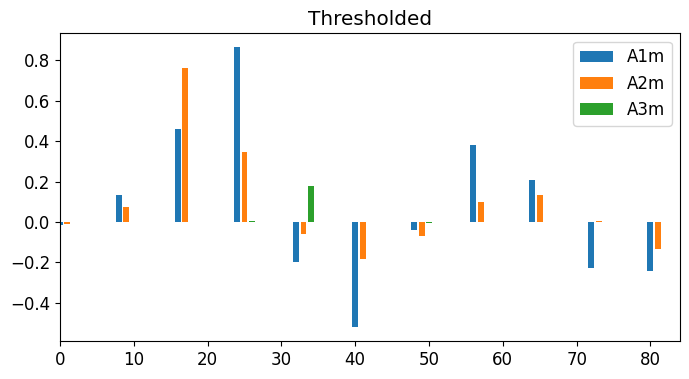

In [19]:
plt.rcParams['figure.figsize'] = [8,4]

Atot = np.column_stack((A1m,A2m,A3m)) # Average loadings of three methods
Atot2 = (Atot>0.2) * Atot # threshold
Atot3 = np.column_stack((Atot,Atot2)) # combine both thresholded and not

for j in range(3):
    plt.bar(np.arange(Atot.shape[0])*4+j,Atot[:,j],label='A'+str(j+1)+'m')

plt.xlim(0,4*M)
plt.title('Unthresholded')
plt.legend()

plt.figure()
for j in range(3):
    plt.bar(np.arange(Atot2.shape[0])*8+j,Atot[:,j],label='A'+str(j+1)+'m')

plt.title('Thresholded')
plt.xlim(0,4*M)
plt.legend()

plt.show()

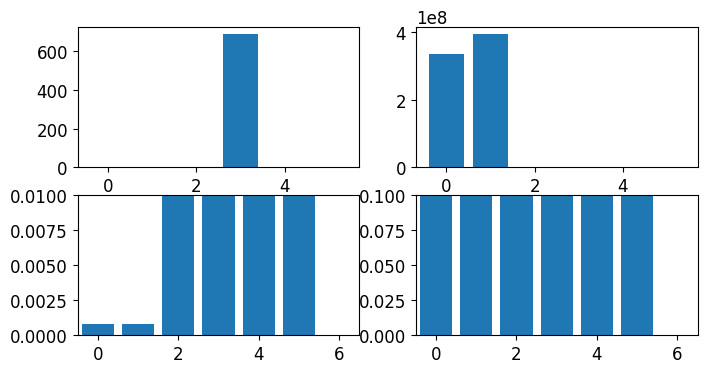

In [20]:
n = 200
L = 8
x = np.linspace(0,L,n)
x1 = x[:100]    # Train
x2 = x[100:200] # Test
n1 = len(x1)
n2 = len(x2)
ftrain = np.power(x1,2) # Train parabola x = [0,4]
ftest = np.power(x2,2)  # Test parabola x = [4,8]

phi_i = np.zeros((n1,M))
phi_e = np.zeros((n2,M))

for j in range(M):
    phi_i[:,j] = np.power(x1,j) # interpolation key
    phi_e[:,j] = np.power(x2,j) # extrapolation key

Eni = np.zeros(6)
Ene = np.zeros(6)
for jj in range(6): # compute inter/extra-polation scores
    ani = Atot3[:,jj]
    fnai = phi_i @ ani
    Eni[jj] = np.linalg.norm(ftrain-fnai,ord=2)/np.linalg.norm(ftrain,ord=2)
    fnae = phi_e @ ani
    Ene[jj] = np.linalg.norm(ftest-fnae,ord=2)/np.linalg.norm(ftest,ord=2)

fig,axs = plt.subplots(2,2)
axs[0,0].bar(range(6),Eni)
axs[0,1].bar(range(6),Ene)
axs[1,0].bar(range(6),Eni)
axs[1,0].set_xlim(-0.5,6.5)
axs[1,0].set_ylim(0,0.01)
axs[1,1].bar(range(6),Ene)
axs[1,1].set_xlim(-0.5,6.5)
axs[1,1].set_ylim(0,0.1)

plt.show()